# GAIN Code
Notebook implementing the GAIN code for two datasets - Spam and Letters - from the UCI repository

In [162]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

%matplotlib inline

#### Data - read in Spam and Letters datasets

In [163]:
spam = pd.read_csv("spambase.data", header=None)
letters = pd.read_csv("letter-recognition.data", header=None)

In [164]:
spam_data = spam.iloc[:,:57]
letters_data = letters.iloc[:,1:]
spam_labels = spam.iloc[:,57]
letters_labels = letters.iloc[:,0]

### GAIN Class

In [165]:
class GAIN:
    def __init__(self, Data):
        self.Data = Data
        
        # Parameters
        self.No = len(Data)
        self.Dim = len(Data[0,:])

        # Hidden layer parameters
        self.H_Dim1 = self.Dim
        self.H_Dim2 = self.Dim
        
        # Test and training sets
        self.trainX = None
        self.testX = None

        # Train / Test Missing Indicators
        self.trainM = None
        self.testM = None

        self.train_indices = None
        self.test_indices = None
        
    def normalize(self):
        # Normalization (0 to 1)
        Min_Val = np.zeros(self.Dim)
        Max_Val = np.zeros(self.Dim)

        for i in range(self.Dim):
            Min_Val[i] = np.min(self.Data[:,i])
            self.Data[:,i] = self.Data[:,i] - np.min(self.Data[:,i])
            Max_Val[i] = np.max(self.Data[:,i])
            self.Data[:,i] = self.Data[:,i] / (np.max(self.Data[:,i]) + 1e-6)    

    def create_missing(self, p_miss):
                       
        #%% Missing introducing
        p_miss_vec = p_miss * np.ones((self.Dim,1)) 

        self.Missing = np.zeros((self.No,self.Dim))

        for i in range(self.Dim):
            A = np.random.uniform(0., 1., size = [len(self.Data),])
            B = A > p_miss_vec[i]
            self.Missing[:,i] = 1.*B

    def train_test_split(self, train_rate):
        #%% Train Test Division    

        idx = np.random.permutation(self.No)

        self.Train_No = int(self.No * train_rate)
        self.Test_No = self.No - self.Train_No

        # Train / Test Features
        self.trainX = self.Data[idx[:self.Train_No],:]
        self.testX = self.Data[idx[self.Train_No:],:]

        # Train / Test Missing Indicators
        self.trainM = self.Missing[idx[:self.Train_No],:]
        self.testM = self.Missing[idx[self.Train_No:],:]
        
        self.train_indices = idx[:self.Train_No]
        self.test_indices = idx[self.Train_No:]

    # Helper functions
    def xavier_init(self, size):
        # 1. Xavier Initialization Definition
        in_dim = size[0]
        xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
        return tf.random_normal(shape = size, stddev = xavier_stddev)
    
    def sample_M(self, m, n, p):
        # Hint Vector Generation
        A = np.random.uniform(0., 1., size = [m, n])
        B = A > p
        C = 1.*B
        return C

    #%% GAIN Function

    #%% 1. Generator
    def generator(self, new_x, m, G_W1, G_W2, G_W3, G_b1, G_b2, G_b3):
        inputs = tf.concat(axis = 1, values = [new_x,m])  # Mask + Data Concatenate
        G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
        G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)   
        G_prob = tf.nn.sigmoid(tf.matmul(G_h2, G_W3) + G_b3) # [0,1] normalized Output
        return G_prob

    #%% 2. Discriminator
    def discriminator(self, new_x, h, D_W1, D_W2, D_W3, D_b1, D_b2, D_b3):
        inputs = tf.concat(axis = 1, values = [new_x,h])  # Hint + Data Concatenate
        D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)  
        D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
        D_logit = tf.matmul(D_h2, D_W3) + D_b3
        D_prob = tf.nn.sigmoid(D_logit)  # [0,1] Probability Output
        return D_prob

    #%% 3. Other functions
    # Random sample generator for Z
    def sample_Z(self, m, n):
        return np.random.uniform(0., 0.01, size = [m, n])        

    # Mini-batch generation
    def sample_idx(self, m, n):
        A = np.random.permutation(m)
        idx = A[:n]
        return idx
        
    def gain_network(self, mb_size, p_hint, alpha, verbose=False):
        '''
        GAIN Consists of 3 Components
        - Generator
        - Discriminator
        - Hint Mechanism
        '''   

        #%% GAIN Architecture   

        #%% 1. Input Placeholders
        # 1.1. Data Vector
        X = tf.placeholder(tf.float32, shape = [None, self.Dim])
        # 1.2. Mask Vector 
        M = tf.placeholder(tf.float32, shape = [None, self.Dim])
        # 1.3. Hint vector
        H = tf.placeholder(tf.float32, shape = [None, self.Dim])
        # 1.4. X with missing values
        New_X = tf.placeholder(tf.float32, shape = [None, self.Dim])

        #%% 2. Discriminator
        D_W1 = tf.Variable(self.xavier_init([self.Dim*2, self.H_Dim1]))     # Data + Hint as inputs
        D_b1 = tf.Variable(tf.zeros(shape = [self.H_Dim1]))

        D_W2 = tf.Variable(self.xavier_init([self.H_Dim1, self.H_Dim2]))
        D_b2 = tf.Variable(tf.zeros(shape = [self.H_Dim2]))

        D_W3 = tf.Variable(self.xavier_init([self.H_Dim2, self.Dim]))
        D_b3 = tf.Variable(tf.zeros(shape = [self.Dim]))       # Output is multi-variate

        theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

        #%% 3. Generator
        G_W1 = tf.Variable(self.xavier_init([self.Dim*2, self.H_Dim1]))     # Data + Mask as inputs (Random Noises are in Missing Components)
        G_b1 = tf.Variable(tf.zeros(shape = [self.H_Dim1]))

        G_W2 = tf.Variable(self.xavier_init([self.H_Dim1, self.H_Dim2]))
        G_b2 = tf.Variable(tf.zeros(shape = [self.H_Dim2]))

        G_W3 = tf.Variable(self.xavier_init([self.H_Dim2, self.Dim]))
        G_b3 = tf.Variable(tf.zeros(shape = [self.Dim]))

        theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]



        #%% Structure
        # Generator
        G_sample = self.generator(New_X, M, G_W1, G_W2, G_W3, G_b1, G_b2, G_b3)

        # Combine with original data
        Hat_New_X = New_X * M + G_sample * (1-M)

        # Discriminator
        D_prob = self.discriminator(Hat_New_X, H, D_W1, D_W2, D_W3, D_b1, D_b2, D_b3)

        #%% Loss
        D_loss1 = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1-M) * tf.log(1. - D_prob + 1e-8)) 
        G_loss1 = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))
        MSE_train_loss = tf.reduce_mean((M * New_X - M * G_sample)**2) / tf.reduce_mean(M)

        D_loss = D_loss1
        G_loss = G_loss1 + alpha * MSE_train_loss 

        #%% MSE Performance metric
        MSE_test_loss = tf.reduce_mean(((1-M) * X - (1-M)*G_sample)**2) / tf.reduce_mean(1-M)

        #%% Solver
        D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
        G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

        # Sessions
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        #%% Iterations

        #%% Start Iterations
        for it in tqdm(range(5000)):    

            #%% Inputs
            mb_idx = self.sample_idx(self.Train_No, mb_size)
            X_mb = self.trainX[mb_idx,:]  

            Z_mb = self.sample_Z(mb_size, self.Dim) 
            M_mb = self.trainM[mb_idx,:]  
            H_mb1 = self.sample_M(mb_size, self.Dim, 1-p_hint)
            H_mb = M_mb * H_mb1

            New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce

            _, D_loss_curr = sess.run([D_solver, D_loss1], feed_dict = {M: M_mb, New_X: New_X_mb, H: H_mb})
            _, G_loss_curr, MSE_train_loss_curr, MSE_test_loss_curr = sess.run([G_solver, G_loss1, MSE_train_loss, MSE_test_loss],
                                                                               feed_dict = {X: X_mb, M: M_mb, New_X: New_X_mb, H: H_mb})

            if verbose==True:
                #%% Intermediate Losses
                if it % 1000 == 0:
                    print('Iter: {}'.format(it))
                    print('Train_loss: {:.4}'.format(np.sqrt(MSE_train_loss_curr)))
                    print('Test_loss: {:.4}'.format(np.sqrt(MSE_test_loss_curr)))
                    print()

        Z_mb = self.sample_Z(self.Test_No, self.Dim) 
        M_mb = self.testM
        X_mb = self.testX

        New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce

        MSE_final, Sample = sess.run([MSE_test_loss, G_sample], feed_dict = {X: self.testX, M: self.testM, New_X: New_X_mb})

        print('Final Test RMSE: ' + str(np.sqrt(MSE_final)))
        return(Sample)

### Loop through various levels of missingness

#### Global parameters

In [166]:
# 1. Mini batch size
mb_size = 128
# 2. Hint rate
p_hint = 0.9
# 3. Loss Hyperparameters
alpha = 10
# 4. Train Rate
train_rate = 0.8

Helper function for scoring imputation method 

In [167]:
def imputation_rmse(M_test, X_test, X_test_impute):
    return(np.sqrt(np.mean(((1-M_test) * X_test - (1-M_test)*X_test_impute)**2) / np.mean(1-M_test)))
    

In [160]:
rmses = np.zeros((2,4,3))
count_data = 0
for Data in [spam_data.values*1.0, letters_data.values*1.0]:
    print(Data[0,:])
    gain = GAIN(Data)
    # Normalize the data
    gain.normalize()
    
    
    count_miss = 0
    for p_miss in [.2, .4, .6, .8]:
        
        # Create missing value matrix
        gain.create_missing(p_miss)
        # Create train and test split
        gain.train_test_split(train_rate)

        # Get test missing value matrix and test data
        M_test = gain.testM
        X_test = gain.testX

        # GAIN approach - this returns the imputation of the test matrix
        gan_imputed = gain.gain_network(mb_size, p_hint, alpha)

        # Zeros approach (just impute with 0)
        zero_imputed = X_test*M_test

        # Means approach
        impute_means = np.reshape(np.sum(X_test * M_test, axis=0)/np.sum(M_test,axis=0),(1,gain.Dim))
        impute_means = np.repeat(impute_means, M_test.shape[0], axis=0)
        mean_imputed = X_test*M_test + impute_means * (1-M_test)

        zeros_rmse = imputation_rmse(M_test, X_test, zero_imputed)
        mean_rmse = imputation_rmse(M_test, X_test, mean_imputed)
        gan_rmse = imputation_rmse(M_test, X_test, gan_imputed)
        
        rmses[count_data, count_miss,0] = zeros_rmse
        rmses[count_data, count_miss,1] = mean_rmse
        rmses[count_data, count_miss,2] = gan_rmse
        
        print('Zeros imputation performance: {0}'.format(zeros_rmse))
        print('Mean imputation performance: {0}'.format(mean_rmse))
        print('GAN imputation performance: {0}'.format(gan_rmse))
        
        count_miss += 1
        
    count_data += 1

[  0.      0.64    0.64    0.      0.32    0.      0.      0.      0.
   0.      0.      0.64    0.      0.      0.      0.32    0.      1.29
   1.93    0.      0.96    0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.778   0.      0.
   3.756  61.    278.   ]


100%|██████████| 5000/5000 [00:17<00:00, 292.67it/s]


Final Test RMSE: 0.056389973
Zeros imputation performance: 0.06538530414127323
Mean imputation performance: 0.060929070371775355
GAN imputation performance: 0.056389971540183784


100%|██████████| 5000/5000 [00:16<00:00, 297.85it/s]


Final Test RMSE: 0.056701936
Zeros imputation performance: 0.06214142935058769
Mean imputation performance: 0.05806278576677495
GAN imputation performance: 0.05670193612491822


100%|██████████| 5000/5000 [00:16<00:00, 300.08it/s]


Final Test RMSE: 0.13363135
Zeros imputation performance: 0.058477023857035126
Mean imputation performance: 0.05386657644246834
GAN imputation performance: 0.13363137355276153


100%|██████████| 5000/5000 [00:17<00:00, 293.94it/s]


Final Test RMSE: 0.11190571
Zeros imputation performance: 0.06236749312154788
Mean imputation performance: 0.05832200127353609
GAN imputation performance: 0.11190573057648794
[ 2.  8.  3.  5.  1.  8. 13.  0.  6.  6. 10.  8.  0.  8.  0.  8.]


100%|██████████| 5000/5000 [00:10<00:00, 483.05it/s]


Final Test RMSE: 0.12681715
Zeros imputation performance: 0.43811967869834323
Mean imputation performance: 0.15308224562290296
GAN imputation performance: 0.12681714621656065


100%|██████████| 5000/5000 [00:10<00:00, 484.11it/s]


Final Test RMSE: 0.13470462
Zeros imputation performance: 0.43872004417470983
Mean imputation performance: 0.1524596132747638
GAN imputation performance: 0.13470462837361907


100%|██████████| 5000/5000 [00:10<00:00, 481.35it/s]


Final Test RMSE: 0.16640882
Zeros imputation performance: 0.4401498931213414
Mean imputation performance: 0.15497874797933034
GAN imputation performance: 0.16640881414739578


100%|██████████| 5000/5000 [00:10<00:00, 475.99it/s]


Final Test RMSE: 0.20769054
Zeros imputation performance: 0.44070386503041403
Mean imputation performance: 0.1534306694340786
GAN imputation performance: 0.2076905420049601


In [168]:
rmses

array([[[0.0653853 , 0.06092907, 0.05638997],
        [0.06214143, 0.05806279, 0.05670194],
        [0.05847702, 0.05386658, 0.13363137],
        [0.06236749, 0.058322  , 0.11190573]],

       [[0.43811968, 0.15308225, 0.12681715],
        [0.43872004, 0.15245961, 0.13470463],
        [0.44014989, 0.15497875, 0.16640881],
        [0.44070387, 0.15343067, 0.20769054]]])

In [175]:
rmses[1][:,0]

array([0.43811968, 0.43872004, 0.44014989, 0.44070387])

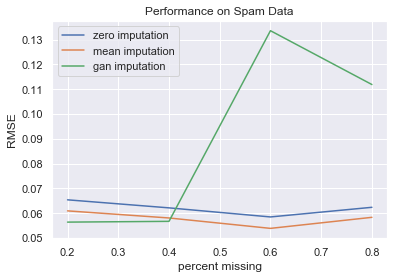

In [182]:
plt.plot([.2,.4,.6,.8], rmses[0][:,0], label='zero imputation')
plt.plot([.2,.4,.6,.8], rmses[0][:,1], label='mean imputation')
plt.plot([.2,.4,.6,.8], rmses[0][:,2], label='gan imputation' )
plt.xlabel('percent missing')
plt.ylabel('RMSE')
plt.legend(loc='upper left')
plt.title('Performance on Spam Data')
plt.show()

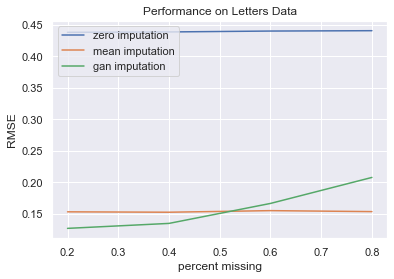

In [183]:
plt.plot([.2,.4,.6,.8], rmses[1][:,0],label='zero imputation')
plt.plot([.2,.4,.6,.8], rmses[1][:,1],label='mean imputation')
plt.plot([.2,.4,.6,.8], rmses[1][:,2],label='gan imputation' )
plt.xlabel('percent missing')
plt.ylabel('RMSE')
plt.legend(loc='upper left')
plt.title('Performance on Letters Data')
plt.show()